In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
np.random.seed(42)

In [2]:
# сейвим картинки
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "exitimg"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# игнорим минорные ворнинги SciPy
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
# трансформеры
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

# трансформируем pd в np
def PdtoNp(some_data):
    return some_data.values

In [4]:
# стандартизируем перегоняем в пандас и стандартизируем масштаб
transform_pipeline = Pipeline([
        ('pd_to_np', FunctionTransformer(PdtoNp, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

In [5]:
def area(box):
    return (box[2] - box[0]) * (box[3] - box[1])


def intersection_over_union(boxes):
    assert(len(boxes) == 8)
    boxA = boxes[:4].values
    boxB = boxes[4:].values
    
    boxAArea = area(boxA)
    boxBArea = area(boxB)
    
    if (boxAArea == 0 or boxBArea == 0):
        return 0
        
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [6]:
votes = pd.read_csv("final_data/train_data.csv")

In [7]:
answers = pd.read_csv("final_data/train_answers.csv")

In [8]:
clear_votes = pd.read_csv("final_data/test_data.csv")

In [9]:
quorum = votes.groupby("itemId")[['Xmin','Ymin', 'Xmax', 'Ymax']].mean().reset_index()

In [10]:
data = quorum.merge(answers, on=["itemId"])

In [11]:
data["iou"] = data[['Xmin','Ymin', 'Xmax', 'Ymax', 'Xmin_true',\
      'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)

In [12]:
data["iou"].mean()

0.5058725791429202

In [13]:
# делаем новые признаки
def syntesator(pd_massive):
    pd_massive['Xstart'] = pd_massive[['Xmax','Xmin']].apply(max, axis=1)
    pd_massive['Xstop'] = pd_massive[['Xmax','Xmin']].apply(min, axis=1)
    pd_massive['width'] = pd_massive['Xstart'] - votes['Xstop']
    pd_massive['Ystart'] = pd_massive[['Ymax','Ymin']].apply(max, axis=1)
    pd_massive['Ystop'] = pd_massive[['Ymax','Ymin']].apply(min, axis=1)
    pd_massive['height'] = pd_massive['Ystart'] - votes['Ystop']
    return pd_massive

In [14]:
votes = syntesator(votes)
clear_votes = syntesator(clear_votes)

In [15]:
answers['Xstart_true'] = answers[['Xmax_true','Xmin_true']].apply(max, axis=1)
answers['Xstop_true'] = answers[['Xmax_true','Xmin_true']].apply(min, axis=1)
answers['width_true'] = answers['Xstart_true'] - answers['Xstop_true']
answers['Ystart_true'] = answers[['Ymax_true','Ymin_true']].apply(max, axis=1)
answers['Ystop_true'] = answers[['Ymax_true','Ymin_true']].apply(min, axis=1)
answers['height_true'] = answers['Ystart_true'] - answers['Ystop_true']

In [16]:
# собираем весь сет данных в один массив
full_set = votes.merge(answers, how='left', on='itemId', sort=False)
print("Sanity check: ", sum(full_set.index - votes.index))

Sanity check:  0


In [17]:
# полный сет с iou
full_set_quorum = full_set.copy()
full_set_quorum["iou"] = full_set[['Xmin','Ymin', 'Xmax', 'Ymax', 'Xmin_true',\
      'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)
full_set_quorum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5337 entries, 0 to 5336
Data columns (total 23 columns):
userId         5337 non-null int64
itemId         5337 non-null int64
Xmin           5337 non-null int64
Ymin           5337 non-null int64
Xmax           5337 non-null int64
Ymax           5337 non-null int64
Xstart         5337 non-null int64
Xstop          5337 non-null int64
width          5337 non-null int64
Ystart         5337 non-null int64
Ystop          5337 non-null int64
height         5337 non-null int64
Xmin_true      5337 non-null int64
Ymin_true      5337 non-null int64
Xmax_true      5337 non-null int64
Ymax_true      5337 non-null int64
Xstart_true    5337 non-null int64
Xstop_true     5337 non-null int64
width_true     5337 non-null int64
Ystart_true    5337 non-null int64
Ystop_true     5337 non-null int64
height_true    5337 non-null int64
iou            5337 non-null float64
dtypes: float64(1), int64(22)
memory usage: 1000.7 KB


In [18]:
# делаем тестовые выборки
X = full_set.drop(['userId', 'itemId', 'Xmin_true','Ymin_true', 'Xmax_true', 'Ymax_true', 'Xstart_true',
                                       'Xstop_true', 'width_true', 'Ystart_true', 'Ystop_true', 'height_true'], axis=1)
y = full_set_quorum["iou"]
print(X.shape)
print(y.shape)
N, d = X.shape

(5337, 10)
(5337,)


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

4002 1335


In [20]:
X_train = transform_pipeline.fit_transform(X_train)
X_test = transform_pipeline.fit_transform(X_test)

C:\Users\Konstantin.mne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Konstantin.mne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Konstantin.mne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Konstantin.mne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [21]:
# базовые модели
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
def plot_feature_importances(model, data):
    n_features = data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align="center")
    plt.xlabel("importance")
    plt.ylabel("feature")

In [22]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [23]:
tree_scores = cross_val_score(tree_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [24]:
display_scores(tree_rmse_scores)
pd.Series(np.sqrt(-tree_scores)).describe()

Scores: [0.17837198 0.17660838 0.19796352 0.18695243 0.18477339 0.19569657
 0.19013837 0.18669347 0.19219971 0.20201229]
Mean: 0.18914101096258187
Standard deviation: 0.007744208859485251


count    10.000000
mean      0.189141
std       0.008163
min       0.176608
25%       0.185253
50%       0.188545
75%       0.194822
max       0.202012
dtype: float64

In [25]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [26]:
lin_scores = cross_val_score(lin_reg, X_train, y_train,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)
pd.Series(np.sqrt(-lin_scores)).describe()

Scores: [0.1655147  0.16895988 0.16273489 0.17041143 0.17079565 0.16643754
 0.17185896 0.1793827  0.16951575 0.16900303]
Mean: 0.1694614533851344
Standard deviation: 0.004210627772206555


count    10.000000
mean      0.169461
std       0.004438
min       0.162735
25%       0.167068
50%       0.169259
75%       0.170700
max       0.179383
dtype: float64

In [27]:
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [28]:
forest_scores = cross_val_score(forest_reg, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)
pd.Series(np.sqrt(-forest_scores)).describe()

Scores: [0.14720531 0.14171782 0.13090429 0.13502636 0.13923757 0.13770909
 0.1402078  0.14549244 0.14776964 0.14472409]
Mean: 0.14099944089911612
Standard deviation: 0.005206452257693672


count    10.000000
mean      0.140999
std       0.005488
min       0.130904
25%       0.138091
50%       0.140963
75%       0.145300
max       0.147770
dtype: float64

In [29]:
# протестим сеты из 18 гиперпараметрах. 6 прогонов, итого 90 раундов. Решающие деревья
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [30]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

In [31]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [32]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.16033745160592705 {'max_features': 2, 'n_estimators': 3}
0.14272252401631397 {'max_features': 2, 'n_estimators': 10}
0.13777941338440816 {'max_features': 2, 'n_estimators': 30}
0.15924654734152405 {'max_features': 4, 'n_estimators': 3}
0.14325977835644887 {'max_features': 4, 'n_estimators': 10}
0.13837801888589538 {'max_features': 4, 'n_estimators': 30}
0.1583761755530193 {'max_features': 6, 'n_estimators': 3}
0.14319313764282052 {'max_features': 6, 'n_estimators': 10}
0.13854510589249433 {'max_features': 6, 'n_estimators': 30}
0.15682177651126025 {'max_features': 8, 'n_estimators': 3}
0.14322006997947842 {'max_features': 8, 'n_estimators': 10}
0.1393314942423791 {'max_features': 8, 'n_estimators': 30}
0.1579051730087793 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.14362522275265077 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.15602855847099267 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.14200553665346172 {'bootstrap': False, 'max_fea

In [33]:
# относительная значимость
importance_for_rand_forest = grid_search.best_estimator_.feature_importances_
importance_for_rand_forest

array([0.12299292, 0.06832801, 0.08341329, 0.07151884, 0.08551166,
       0.13242403, 0.15026922, 0.0743397 , 0.06730511, 0.14389723])

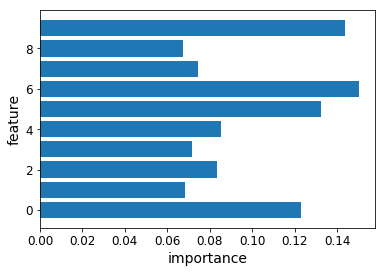

In [34]:
plot_feature_importances(grid_search.best_estimator_, X_train)

In [35]:
X.head(1)

,Xmin,Ymin,Xmax,Ymax,Xstart,Xstop,width,Ystart,Ystop,height
0,62,656,276,803,276,62,214,803,656,147


In [36]:
# далее попробуем сократить кол-во решающих параметров
X1 = full_set.drop(['itemId', 'userId', 'Xmin_true','Ymin_true', 
                    'Xmax_true', 'Ymax_true', 'Xstart_true', 'Xstop_true', 'width_true', 'Ystart_true', 
                    'Ystop_true', 'height_true', 'Xstart', 'Xstop', 'Ystart', 'Ystop', 'height', 'width'], axis=1)
print(X1.shape)
print(y.shape)
N, d = X1.shape

(5337, 4)
(5337,)


In [37]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size = 0.25, random_state = 42)
N1_train, _ = X1_train.shape 
print(N1_train, N_test)

4002 1335


In [38]:
X1_train = transform_pipeline.fit_transform(X1_train)
X1_test = transform_pipeline.fit_transform(X1_test)

C:\Users\Konstantin.mne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Konstantin.mne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Konstantin.mne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Konstantin.mne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [39]:
synt_forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
synt_forest_reg.fit(X1_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [40]:
synt_forest_scores = cross_val_score(synt_forest_reg, X1_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
synt_forest_rmse_scores = np.sqrt(-synt_forest_scores)
display_scores(synt_forest_rmse_scores)
pd.Series(np.sqrt(-synt_forest_scores)).describe()

Scores: [0.15201817 0.14482293 0.13647615 0.14900834 0.14331686 0.14163985
 0.14994623 0.15507898 0.15763877 0.15220878]
Mean: 0.14821550537386474
Standard deviation: 0.006216861100993657


count    10.000000
mean      0.148216
std       0.006553
min       0.136476
25%       0.143693
50%       0.149477
75%       0.152161
max       0.157639
dtype: float64

In [41]:
synt_param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 3, 4]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
synt_grid_search = GridSearchCV(synt_forest_reg, synt_param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
synt_grid_search.fit(X1_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 3, 4]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [42]:
synt_grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

In [43]:
synt_grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [44]:
importance_for_synt_rand_forest = synt_grid_search.best_estimator_.feature_importances_
importance_for_synt_rand_forest

array([0.33028705, 0.18276862, 0.28092229, 0.20602204])

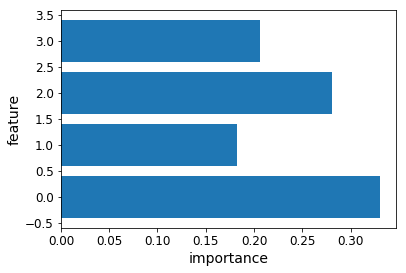

In [45]:
plot_feature_importances(synt_grid_search.best_estimator_, X1_train)

In [46]:
X1.head(1)

,Xmin,Ymin,Xmax,Ymax
0,62,656,276,803


Получилось хуже, к базовой модели:

In [47]:
X_full = transform_pipeline.fit_transform(X)
prediction = grid_search.best_estimator_.predict(X_full)

C:\Users\Konstantin.mne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Konstantin.mne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [48]:
# добавим в полный сет предсказания
full_set['prediction'] = prediction

In [49]:
# дропнем предсказания хуже 0.6
iou_drop = full_set[full_set['prediction']<0.6]
droped_full_set = full_set.drop(iou_drop.index, axis=0)
droped_full_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 728 entries, 0 to 5323
Data columns (total 23 columns):
userId         728 non-null int64
itemId         728 non-null int64
Xmin           728 non-null int64
Ymin           728 non-null int64
Xmax           728 non-null int64
Ymax           728 non-null int64
Xstart         728 non-null int64
Xstop          728 non-null int64
width          728 non-null int64
Ystart         728 non-null int64
Ystop          728 non-null int64
height         728 non-null int64
Xmin_true      728 non-null int64
Ymin_true      728 non-null int64
Xmax_true      728 non-null int64
Ymax_true      728 non-null int64
Xstart_true    728 non-null int64
Xstop_true     728 non-null int64
width_true     728 non-null int64
Ystart_true    728 non-null int64
Ystop_true     728 non-null int64
height_true    728 non-null int64
prediction     728 non-null float64
dtypes: float64(1), int64(22)
memory usage: 136.5 KB


In [50]:
# посмотрим какой iou
droped_full_set = droped_full_set.drop(['userId', 'Xstart', 'Xstop', 'width', 'Ystart', 'Ystop', 'height', 
                                        'Xstart_true', 'Xstop_true', 'width_true', 'Ystart_true', 
                                        'Ystop_true', 'height_true', 'prediction'], axis=1)

In [51]:
droped_full_set["iou"] = droped_full_set[['Xmin','Ymin', 'Xmax', 'Ymax', 'Xmin_true', 
                                          'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)

In [52]:
droped_full_set["iou"].mean()

0.7033917622417505

In [53]:
X_full_test = clear_votes.drop(['userId', 'itemId'], axis=1)
X_full_test.head(1)

,Xmin,Ymin,Xmax,Ymax,Xstart,Xstop,width,Ystart,Ystop,height
0,86,640,242,743,242,86,180.0,743,640,87.0


In [54]:
# на тесте
X_full_test = transform_pipeline.fit_transform(X_full_test)

In [55]:
prediction_test = grid_search.best_estimator_.predict(X_full_test)

In [56]:
clear_votes['prediction'] = prediction_test
iou_drop_test = clear_votes[clear_votes['prediction']<0.6]
droped_clear_votes = clear_votes.drop(iou_drop_test.index, axis=0)
droped_full_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 728 entries, 0 to 5323
Data columns (total 10 columns):
itemId       728 non-null int64
Xmin         728 non-null int64
Ymin         728 non-null int64
Xmax         728 non-null int64
Ymax         728 non-null int64
Xmin_true    728 non-null int64
Ymin_true    728 non-null int64
Xmax_true    728 non-null int64
Ymax_true    728 non-null int64
iou          728 non-null float64
dtypes: float64(1), int64(9)
memory usage: 62.6 KB


In [57]:
droped_clear_votes = droped_clear_votes.drop(['userId', 'Xstart', 'Xstop', 'width', 'Ystart', 'Ystop', 'height', 
                                        'prediction'], axis=1)

In [58]:
droped_clear_votes.to_csv('final_data/submission.csv', index=False, header=False)

Увы, это не входит в условия задачи в конкурсе - мы там предсказываем координаты углов.
В принципе идею можно развивать дальше и на основе предсказанного iou предсказывать координаты